## Initial setup

In [61]:
import dateutil
import numpy as np
import pandas as pd
import simplejson as json
import wordcloud

In [19]:
with open('secrets.txt', 'r') as f:
    env = json.load(f)
print('Loaded env vars')

Loaded env vars


## Quick tokenization and sentiment

In [ ]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

tokenized_train_tweets = [(tweet_tokenizer.tokenize(t),l) for t,l in train_tweets]

print(len(tokenized_train_tweets))
print(tokenized_train_tweets[0])

In [ ]:
import nltk
nltk.download('twitter_samples')

In [ ]:
from nltk.corpus import twitter_samples

In [ ]:
pos_tweets = [(t, 'pos') for t in twitter_samples.strings('positive_tweets.json')]
neg_tweets = [(t, 'neg') for t in twitter_samples.strings('negative_tweets.json')]
print(len(pos_tweets))
print(len(neg_tweets))

In [ ]:
import random

random.shuffle(pos_tweets)
random.shuffle(neg_tweets)

In [ ]:
train_pos_tweets = pos_tweets[:4500]
test_pos_tweets = pos_tweets[4500:]

train_neg_tweets = neg_tweets[:4500]
test_neg_tweets = neg_tweets[4500:]

train_tweets = train_pos_tweets + train_neg_tweets
test_tweets = test_pos_tweets + test_neg_tweets

print(len(train_tweets))
print(len(test_tweets))

In [ ]:
from nltk.sentiment import SentimentAnalyzer

sentim_analyzer = SentimentAnalyzer()

In [ ]:
all_words = sentim_analyzer.all_words(tokenized_train_tweets)
print(len(all_words))
print(all_words[0:10])

In [ ]:
from nltk.sentiment.util import extract_unigram_feats

unigram_feats = sentim_analyzer.unigram_word_feats(all_words, min_freq=4)
print(len(unigram_feats))
print(unigram_feats[0:20])
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [ ]:
training_set = sentim_analyzer.apply_features(train_tweets)
test_set = sentim_analyzer.apply_features(test_tweets)

In [ ]:
from nltk.classify import NaiveBayesClassifier

trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key, value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))

In [ ]:
# t = 'RT @RedditBTC: Russia plans $10 Billion Bitcoin investment... so it begins. https://t.co/vSSeeZWG9s'
t = "i don't get bitcoin"
classifier.classify(sentim_analyzer.extract_features(t))

In [ ]:
# import twython
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

trainer = NaiveBayesClassifier.train

# ans = nltk.sentiment.util.demo_tweets(trainer, output='output.txt')

## Retrieving tweets with tweepy

In [ ]:
import tweepy
from tweepy import Cursor

auth = tweepy.OAuthHandler(env[tw_oauth_key], env[tw_oauth_secret])
auth.set_access_token(env[tw_token_key], env[tw_token_secret])

api = tweepy.API(auth)

In [ ]:
bitcoin_tweets = api.search('bitcoin', lang='en', count=100)
print(len(bitcoin_tweets))
print([t.text for t in bitcoin_tweets[0:5]])

In [ ]:
len(bitcoin_tweets)

In [ ]:
cursor = Cursor(api.search, q='bitcoin', lang='en', count=100, tweet_mode='extended')

In [ ]:
tlist = []

for page in cursor.pages(15):
    tlist.extend(page)

print(len(tlist))

In [ ]:
tweets = [t.full_text for t in tlist]
print(len(tweets))

## Using textblob for quick polarity

In [ ]:
from textblob import TextBlob

In [ ]:
for t in tweets[0:50]:
    print('Tweet:\n' + t)
    blob = TextBlob(t)
    sents = blob.sentences
    if len(sents) >= 1:
        sent = sents[0]
        print(sent.sentiment)
    print('')

## Retrieving tweets from ElasticSearch

In [16]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import Document, Date, Text, Integer, Float
from elasticsearch_dsl.connections import connections


In [17]:
# Create a model for tweets stored in the elasticsearch instance:

from elasticsearch_dsl import Document, Date, Text, Integer, Float

class ESTweet(Document):
    created_at = Date()
    stored_at = Date()
    full_text = Text(analyzer='snowball')
    subjectivity = Float()
    polarity = Float()
    author_id = Integer()
    author_followers = Integer()

    class Index:
        name = 'tweets'


In [20]:
# env vars are loaded at the beginning of the file.
client = Elasticsearch(hosts=[env['es_endpoint']])

In [21]:
# Get all tweets from Elasticsearch instance (dangerous without a limit!):

MAX_TWEETS = 10000

search = Search(index='tweets').using(client)\
            .query("match_all")\
            .sort({'created_at': {'order': 'desc'}})[:MAX_TWEETS]
results = search.execute() # results not used at the moment

tweet_hits = []
for hit in search:
    tweet_hits.append(hit)
len(tweet_hits)

10000

In [ ]:
tweet_hits[:10]

In [ ]:
# Not currently used:
# tweet_dicts = [t.to_dict() for t in tweets]

In [22]:
def hitlist_to_dataframe(hit_list):
    """
    Transform tweet hitlist (from Elasticsearch) to a dataframe
    """
    id_strs = []
    created_ats = []
    full_texts = []
    ndropped = 0
    for hit in hit_list:
        id_str = str(hit.meta.id)
        
        if 'created_at' in hit and 'full_text' in hit:
            id_strs.append(id_str)
            created_ats.append(dateutil.parser.parse(hit['created_at']))
            full_texts.append(hit['full_text'])
        else:
            ndropped += 1
    df = pd.DataFrame({'id_str': id_strs, 'created_at': created_ats, 'full_text': full_texts})
    print('ndropped = {}'.format(ndropped))
    return df


In [ ]:
df_tweets = hitlist_to_dataframe(tweet_hits)
tweet_hits = None # ready for garbage collection

df_tweets.head(10)

In [ ]:
df_tweets.set_index(df_tweets['created_at'])
df_tweets = df_tweets.drop(columns=['id_str', 'created_at'])
df_tweets.head()

## Show a wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
# Compile the full corpus for a word cloud:

corpus = ''
for text in df_tweets['full_text']:
    corpus += ' '.join(tweet_tokens(text))
print(len(corpus))

In [ ]:
wordcloud = WordCloud(width=800, height=450, random_state=21, max_font_size=110).generate(corpus)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## NLP on tweets using Sentiment Analysis Dataset (SAD)

### Step 1: Load the data

In [5]:
import matplotlib.pyplot as plt
import nltk.tokenize
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.pipeline
from sklearn import base

In [ ]:
df_sad = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)

In [ ]:
df_sad.shape

In [ ]:
df_sad.head()

In [ ]:
labels_sad = df_sad['Sentiment']
labels_sad.head()

In [ ]:
df_sad = df_sad.drop(columns=['ItemID', 'Sentiment', 'SentimentSource'])
df_sad.head()

### Step 2: A first pass at cleaning

In [38]:
# Custom nltk transformer for cleaning and tokenizing tweets:

class TwitterPreprocessor(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, column='SentimentText'):
        self.column = column
        self.tw_tokenizer = nltk.tokenize.TweetTokenizer(
            strip_handles=True, reduce_len=True, preserve_case=False)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
#         ans = X.copy()
#         ans[self.column] = ans[self.column].apply(self._prepare_tweet)
        ans = X[self.column].apply(self._prepare_tweet)
        return ans
        
    def _prepare_tweet(self, tweet):
        tokens = self.tw_tokenizer.tokenize(tweet)
        clean_tweet = ' '.join([token for token in tokens
                                if len(token) > 1 and not token.startswith('http')])
        return clean_tweet


In [ ]:
tw_preprocessor = TwitterPreprocessor()
df2 = tw_preprocessor.transform(df_sad)
df2.head()

In [ ]:
# min_df is chosen by off-hand estimate. we should search over it.
# try bigrams ASAP
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    ngram_range=(1,1), min_df=100
)

In [ ]:
raise Exception('Caution: this is slow! Comment this exception if you are sure you want to continue')
df3 = tfidf_vectorizer.fit_transform(df2['SentimentText'])
print(df3.shape)

In [ ]:
type(df3)

In [ ]:
tfidf_vectorizer.vocabulary_

In [ ]:
# Reduce the serialized file size
tfidf_vectorizer.stop_words_ = None
tfidf_vectorizer.vocabulary_ = None

In [ ]:
mnb_estimator = sklearn.naive_bayes.MultinomialNB()

# TODO:
# param_grid = {
#     'tfidf_vectorizer__min_df': linspace(0,)
# }

grid_search_cv = sklearn.model_selection.GridSearchCV(
    mnb_estimator, param_grid={'alpha': [0.1, 0.5, 1.0, 10.0]}, cv=5
)

In [ ]:
grid_search_cv.fit(df3, labels_sad)

In [ ]:
best_estimator = grid_search_cv.best_estimator_

In [ ]:
best_estimator

In [ ]:
import dill

dill.dump(tw_preprocessor, open('tw_preprocessor.dill', 'wb'))
dill.dump(tfidf_vectorizer, open('tfidf_vectorizer.dill', 'wb'))
dill.dump(best_estimator, open('best_mnb_estimator.dill', 'wb'))

In [ ]:
pipe = sklearn.pipeline.Pipeline([
    ('tw_preprocessor', tw_preprocessor),
    ('tfidf_vectorizer', tfidf_vectorizer),
    ('estimator', estimator)
])
pipe

### Step ?: Build wordcloud

In [75]:
def build_word_cloud(df, column_name='full_text', **kwargs):
    corpus = ''
    for text in df[column_name]:
        corpus += text
        corpus += ' '

    cloud = wordcloud.WordCloud(
        width=800, height=450, random_state=21, max_font_size=110, background_color='white', **kwargs
    ).generate(corpus)

    plt.figure(figsize=(8, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


In [ ]:
build_word_cloud(df2)

In [ ]:
estimator.predict(df3[0:100])

tab = pd.DataFrame()

In [ ]:
labels_sad[:100]

In [ ]:
tab = df2[:100]
tab['labels_sad'] = labels_sad[:100]
tab['predicted'] = estimator.predict(df3[:100])
tab

In [ ]:
df2.head()

In [ ]:
example = pd.DataFrame({'SentimentText': ['bitcoin is awesome and it will grow this year']})
print(example)

In [ ]:
pipe.predict(example)

## 4. Load pre-trained models

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import dill

In [2]:
tfidf_vectorizer: TfidfVectorizer = dill.load(open('tfidf_vectorizer.dill', 'rb'))
best_estimator: MultinomialNB = dill.load(open('best_mnb_estimator.dill', 'rb'))


/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [39]:
tw_preprocessor = TwitterPreprocessor(column='full_text')

In [40]:
pipe = sklearn.pipeline.Pipeline([
    ('tw_preprocessor', tw_preprocessor),
    ('tfidf_vectorizer', tfidf_vectorizer),
    ('estimator', best_estimator)
])
pipe

Pipeline(memory=None,
     steps=[('tw_preprocessor', TwitterPreprocessor(column='full_text')), ('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=100,
 ...      vocabulary=None)), ('estimator', MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True))])

In [42]:
example = pd.DataFrame({'full_text': ['bitcoin is awesome and it will grow this year']})
print(example)
pipe.predict(example)

                                       full_text
0  bitcoin is awesome and it will grow this year


array([1])

### 4.2. Get tweets from elasticsearch

In [23]:
len(tweet_hits)

10000

In [24]:
df_tweets = hitlist_to_dataframe(tweet_hits)

ndropped = 0


In [43]:
df_tweets.head()

,id_str,created_at,full_text
0,1096273270037307392,2019-02-15 05:01:30,I can confirm now that Token Taxonomy Act has ...
1,1096273259710955520,2019-02-15 05:01:27,RT @FNGhadaki: Developing a #RecoveryPlan for ...
2,1096273257001447424,2019-02-15 05:01:26,RT @Brett_Tamahori: Still the most accurate de...
3,1096273235438497792,2019-02-15 05:01:21,RT @jimfried: #Bitcoin #CyberSecurity #DebitCa...
4,1096273213187911680,2019-02-15 05:01:16,JP Morgan Launches Pale Imitation of the “Frau...


In [44]:
ih_sentiments = pipe.predict(df_tweets)

In [46]:
len(ih_sentiments)

10000

In [47]:
df_tweets['ih_sentiment'] = ih_sentiments

In [50]:
df_tweets.head()

,id_str,created_at,full_text,ih_sentiment
0,1096273270037307392,2019-02-15 05:01:30,I can confirm now that Token Taxonomy Act has ...,0
1,1096273259710955520,2019-02-15 05:01:27,RT @FNGhadaki: Developing a #RecoveryPlan for ...,1
2,1096273257001447424,2019-02-15 05:01:26,RT @Brett_Tamahori: Still the most accurate de...,1
3,1096273235438497792,2019-02-15 05:01:21,RT @jimfried: #Bitcoin #CyberSecurity #DebitCa...,1
4,1096273213187911680,2019-02-15 05:01:16,JP Morgan Launches Pale Imitation of the “Frau...,1


In [53]:
df_tweets['full_text_clean'] = tw_preprocessor.transform(df_tweets)

In [54]:
df_tweets.head()

,id_str,created_at,full_text,ih_sentiment,full_text_clean
0,1096273270037307392,2019-02-15 05:01:30,I can confirm now that Token Taxonomy Act has ...,0,can confirm now that token taxonomy act has be...
1,1096273259710955520,2019-02-15 05:01:27,RT @FNGhadaki: Developing a #RecoveryPlan for ...,1,rt developing #recoveryplan for #bitcoin and d...
2,1096273257001447424,2019-02-15 05:01:26,RT @Brett_Tamahori: Still the most accurate de...,1,rt still the most accurate description of bitc...
3,1096273235438497792,2019-02-15 05:01:21,RT @jimfried: #Bitcoin #CyberSecurity #DebitCa...,1,rt #bitcoin #cybersecurity #debitcards more ji...
4,1096273213187911680,2019-02-15 05:01:16,JP Morgan Launches Pale Imitation of the “Frau...,1,jp morgan launches pale imitation of the fraud...


### 4.3. Wordcloud

In [59]:
from wordcloud import WordCloud

In [84]:
stopwords=['https', 'co', 'rt', 'bitcoin', 'btc', 'the', 'for', 'and', 'is', 'of', 'at', 'to', 'it']

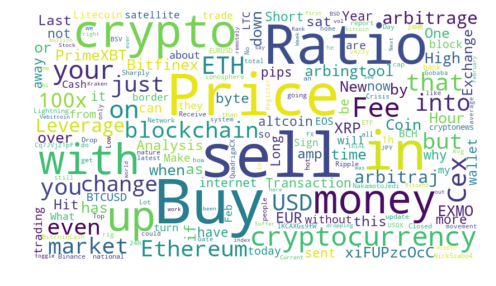

In [85]:
build_word_cloud(df_tweets[df_tweets['ih_sentiment'] == 0], stopwords=stopwords, collocations=False)

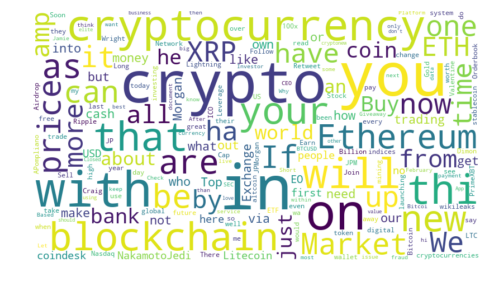

In [86]:
build_word_cloud(df_tweets[df_tweets['ih_sentiment'] == 1], stopwords=stopwords, collocations=False)

## 5. Bokeh

In [ ]:
import bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [ ]:
output_notebook()

In [ ]:
df_tweets.head()

In [ ]:
def get_tb_polarity(tweet):
    blob = textblob.TextBlob(tweet)
    sents = blob.sentences
    if len(sents) >= 1:
        sent = sents[0]
        return float(sent.sentiment.polarity)
    else:
        return np.NaN


In [ ]:
df_tweets['tb_polarity'] = df_tweets['full_text'].apply(get_tb_polarity)
df_tweets.head()

In [ ]:
df_tweets.dtypes

In [ ]:
df_tweets['tb_polarity'].describe()

In [ ]:
s_polarity = pd.Series(data=df_tweets['tb_polarity'].values, index=df_tweets['created_at'].values)
s_polarity = s_polarity.sort_index()
len(s_polarity)

In [ ]:
s_polarity = s_polarity.resample('H').mean()
print(len(s_polarity))
s_polarity.head()

In [ ]:
import bokeh.models

p = figure(
    plot_width=800, plot_height=450,
    tools="",
    x_axis_label='time', y_axis_label='polarity',
    x_axis_type='datetime'
)

# Format background colors:
low_box = bokeh.models.BoxAnnotation(top=0, fill_alpha=0.1, fill_color='red')
high_box = bokeh.models.BoxAnnotation(bottom=0, fill_alpha=0.1, fill_color='green')
p.add_layout(low_box)
p.add_layout(high_box)

# Format gridlines:
p.xgrid[0].grid_line_color=None
p.ygrid[0].grid_line_alpha=0.5

# Format view range:
p.y_range = bokeh.models.Range1d(-1.0, 1.0)

# Prepare data:
cd_source = bokeh.models.ColumnDataSource({'timestamp': s_polarity.index, 'polarity': s_polarity})

p.line('timestamp', 'polarity', source=cd_source, line_width=2)
p.circle('timestamp', 'polarity', source=cd_source, fill_color="white", size=2)

p.add_tools(bokeh.models.HoverTool(
    tooltips=[
        ('time', '@timestamp{%F %H:%M}'),
        ("polarity", "@polarity{+0.00}")
    ],
    formatters={'timestamp': 'datetime', 'polarity': 'numeral'},
    mode='vline'
))


In [ ]:
show(p)